<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/EANet_MRI_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with EANet (External Attention Transformer)

# MRI Brain Tumor Classification

# Requirmenets

In [ ]:
!pip install -U tensorflow-addons
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare the data

In [ ]:
drive.mount('/content/drive', force_remount=True)

num_classes = 4
input_shape = (160, 160, 3)
# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(160, 160),
    #validation_split=0.1,
    #subset="training",
    seed=1024
)

# test data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(160, 160),
    #validation_split=0.1,
    #subset="validation",
    seed=1024
)


Mounted at /content/drive
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Configure the hyperparameters


In [ ]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
batch_size = 128
num_epochs = 30
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")


Patch size: 2 X 2 = 4 
Patches per image: 6400


# Implement the patch extraction and encoding layer


In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


# Implement the external attention block


In [ ]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x


# Implement the MLP block


In [ ]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x


# Implement the Transformer block


In [ ]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x


# Implement the EANet model


In [ ]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    #x = data_augmentation(inputs)
    x = inputs
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# Train on MRI Dataset


In [ ]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5),
    ],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract (PatchExtract)   (None, 6400, 12)     0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (PatchEmbeddin  (None, 6400, 64)    410432      ['patch_extract[0][0]']          
 g)                                                                                               
                                                                                              

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=num_epochs,
)

Epoch 1/30
179/179 [==============================] - 374s 2s/step - loss: 2.2728 - accuracy: 0.5429 - precision: 0.5854 - recall: 0.4562 - f1_score: 0.5042 - val_loss: 1.2430 - val_accuracy: 0.6034 - val_precision: 0.6465 - val_recall: 0.5370 - val_f1_score: 0.5243
Epoch 2/30
179/179 [==============================] - 50s 280ms/step - loss: 0.9496 - accuracy: 0.7183 - precision: 0.7702 - recall: 0.6401 - f1_score: 0.6939 - val_loss: 1.0700 - val_accuracy: 0.7384 - val_precision: 0.7638 - val_recall: 0.7079 - val_f1_score: 0.7111
Epoch 3/30
179/179 [==============================] - 50s 279ms/step - loss: 0.7540 - accuracy: 0.8179 - precision: 0.8542 - recall: 0.7764 - f1_score: 0.8058 - val_loss: 0.9862 - val_accuracy: 0.7872 - val_precision: 0.7997 - val_recall: 0.7735 - val_f1_score: 0.7557
Epoch 4/30
179/179 [==============================] - 50s 279ms/step - loss: 0.6720 - accuracy: 0.8585 - precision: 0.8787 - recall: 0.8272 - f1_score: 0.8445 - val_loss: 0.7611 - val_accuracy: 0

# Let's visualize the training progress of the model.


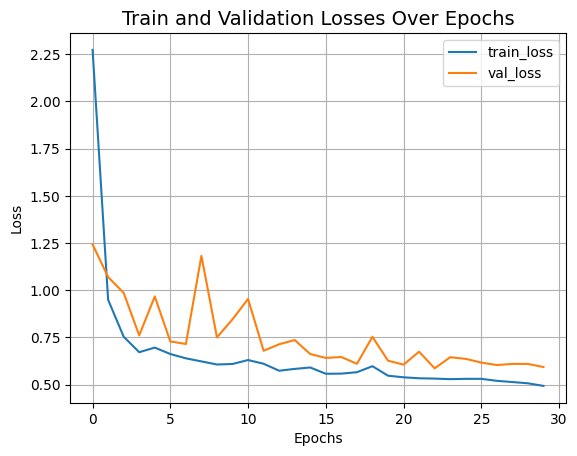

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()
